In [ ]:
""" Jesus Garcia  CSE812 Distributed Systems """

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import math 
import random
import time
import os
from scipy import sparse
from collections import Counter
from pathlib import Path
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import sparse
from scipy.sparse import csr_matrix

In [ ]:
data_list = ["/content/drive/My Drive/CS-812-DistSys-Project/Data/combined_data_1.txt", "/content/drive/My Drive/CS-812-DistSys-Project/Data/combined_data_2.txt", "/content/drive/My Drive/CS-812-DistSys-Project/Data/combined_data_3.txt", "/content/drive/My Drive/CS-812-DistSys-Project/Data/combined_data_4.txt"]


#  UNCOMMENT LINES 6-26 TO RESTRUCTURE THE DATA ONCE IT HAS BEEN DOWNLOADED FROM https://www.kaggle.com/netflix-inc/netflix-prize-data

# for dirname, _, filenames in os.walk('/content/drive/My Drive/CS-812-DistSys-Project/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# if not os.path.isfile('/content/drive/My Drive/CS-812-DistSys-Project/Data/master_dataframe.csv'):
#   master = open('/content/drive/My Drive/CS-812-DistSys-Project/Data/master_dataframe.csv', mode='w')

#   for file in data_list:
#     with open(file) as f:
#       for line in f:
#         line = line.strip()
#         if line.endswith(':'):
#           movid_id = line.replace(':', '')
#         else:
#           v = line.split(',')
#           whole = [x for x in v]
#           whole.insert(0, movid_id)
#           master.write(','.join(whole))
#           master.write('\n')
#   master.close()


#Read from the master dataframe that contains all of the netflix data
#netflix_df = pd.read_csv('/content/drive/My Drive/CS-812-DistSys-Project/Data/master_dataframe.csv', names=['movieID', 'userID', 'rating', 'date'],dtype={'movieId': str, 'userId': str, 'rating': float}, parse_dates = ['date'])

#Select 1k random movies of the entire dataset to work with for ease of use and computational runtime 
#np.random.seed(6)
#select_movies = np.random.choice(netflix_df.movieID.unique(), 5000, replace=False)
#select_users = np.random.choice(netflix_df.userID.unique(), 10000, replace=False)#
#netflix_df = netflix_df[netflix_df.movieID.isin(select_movies)]
#netflix_df = netflix_df[netflix_df.userID.isin(select_users)] #
#netflix_df.to_csv(r'/content/drive/My Drive/CS-812-DistSys-Project/Data/newFormatData.csv', index=False)
#netflix_df.shape
# Create the main dataframe that we will work with where columns are movie ids, rows are user ids and the values are the rating for both the user and movie tuple 

df = pd.read_csv('/content/drive/My Drive/CS-812-DistSys-Project/Data/newFormatData.csv', sep=',')
df.drop(['date'], axis=1, inplace=True)
df.sort_values(by=["userID"], inplace=True)
df = df.reset_index(drop=True)
counter = Counter(df["userID"].values)
test_df = pd.DataFrame()

#Split the dataframe into a train and test set where the training is 80% of the data and testing is 20%

for user in counter:
    if counter[user] >= 2:
        get_this_many = math.floor(counter[user] * .8)
        sample_df = df[df["userID"] == user].sample(n=get_this_many)
        df = df.drop(sample_df.index)
        test_df = pd.concat([test_df, sample_df])
        if len(test_df) >= 6748:
            break

train = df.pivot_table(index="userID", values="rating", columns="movieID")
test = test_df.pivot_table(index="userID", values="rating", columns="movieID")

In [ ]:
df.shape
df.head()

,movieID,userID,rating
11,7155,283,4.0
17,2342,283,4.0
28,11013,283,5.0
30,7281,283,3.0
43,17381,283,4.0


In [ ]:
def DataAnalysis():
  #Distribution Of Ratings for Reduced dataset of 5k users
  df = pd.read_csv('/content/drive/My Drive/CS-812-DistSys-Project/Data/newFormatData.csv', sep=',')
  graph, ax = plt.subplots(figsize=(12, 7))
  sns.countplot(x=df.rating)
  plt.title("Distribution of Ratings for Modified Dataset")
  plt.xlabel('Ratings')
  plt.ylabel('Num of Ratings')
  ax.yaxis.set_major_locator(mticker.FixedLocator(ax.get_yticks().tolist()))
  #ax.set_yticklabels([user(item, 'M') for item in ax.get_yticks()])
  plt.show()

  #Dataset Sparsity
  # d = df.to_numpy()
  # nz = df.shape[0]
  # t = np.product(d.shape)
  # print("\n")
  # print("\n")
  # print("The sparsity of the modified dataset: \n {} % ".format(round((t-nz)/ t, 4)))
  # print("\n")
  # print("\n")

  #Average Rating 
  print("Average rating for the modified dataset: " + str(round(df["rating"].mean(skipna=True),4)))
  print("\n")
  print("\n")


In [ ]:
def BaselineStatisticalMethod(Train, Test):

  Trainp = Train.to_numpy() # Convert Train-setDataframe to Numpy Array
  Testp = Test.to_numpy()# Convert Test-set Dataframe to Numpy Array

  i, j = Trainp.shape # Training Dataset Dimension RowxCol
  ti, tj = Testp.shape # Test Dataset Dimension RowxCol
  u = np.nanmean(Trainp) # Training Dataset observed rating mean

  usr_means = np.nanmean(Trainp, axis=1,dtype=float) # A list of the avg of ratings for each user (mean(bu's))
  itm_means = np.nanmean(Trainp, axis=0,dtype=float) # A list of the avg of each item's ratings (mean(bi's))
  usr_dev = [rt - u for rt in usr_means] # A list of deviations from a user's average to the training set observed ratings average
  itm_dev = [rt - u for rt in itm_means] # A list of deviations from a items's average to the training set observed ratings average

  matrix = BuildPredictionMatrix(Testp, usr_dev, itm_dev, Train.columns.values.tolist(), Test.columns.values.tolist(), Train.index.values.tolist(), Test.index.values.tolist(), u)
  MAE = CalculateMAE(Testp, matrix, u)

  return MAE


def BuildPredictionMatrix(TestData, usr_dev, itm_dev, itm_id_train, itm_id_test, usr_id_train, usr_id_test, u):
  """ This method aims to take the training data (bu and bi deviations and global mean)
      and create a matrix for predictions that will be later evaluated for its similarity 
      to the test set.

      NOTE:The only reason the test data is passed in is to observe the position 
      of where to make the prediction!
      
      """
  ti, tj = TestData.shape
  prediction_matrix = np.empty((ti, tj))
  prediction_matrix[:] = np.NaN
  
  for row in range(0,ti):
    for col in range(0, tj):   
      if(math.isnan(TestData[row][col]) == False): # TestSet is utilized to observe position of where a prediction is needed
          for x in range(0, len(itm_id_train)): # This loop checks the training set's item ids to find the correct deviation for the item on the test set
            if(itm_id_test[col] == itm_id_train[x]):
              for y in range(0, len(usr_id_train)): # This loop checks the training set's user ids to find the correct deviation for the user on the test set
                if(usr_id_test[row] == usr_id_train[y]):
                  bi = itm_dev[x]
                  bu = usr_dev[y]
                  prediction_matrix[row][col] = u + bu + bi # Prediction is made based on the sum of the training set mean, bu & bi deviations to each respective user and item

  return prediction_matrix


def CalculateMAE(Actual, Predicted, u):
    ti, tj = Actual.shape
    n = 0
    sum = 0

    for row in range(0,ti):
      for col in range(0, tj):   
        if(math.isnan(Actual[row][col]) == False and math.isnan(Predicted[row][col]) == False):
          sum = sum + abs((Actual[row][col] - Predicted[row][col]))
          n += 1

    if n == 0:
      n = 1
    return round((sum/n),3)

In [ ]:
def BaselineGradientDescent(Train, Test, DatasetName, iterations):

  Trainp = Train.to_numpy() # Convert Train-setDataframe to Numpy Array
  Testp = Test.to_numpy() # Convert Test-set Dataframe to Numpy Array
  i, j = Trainp.shape # Dimensions of Training Data Row x Col
  iter_list = []
  iter_list.append(0)
  COST_LIST = []
  learning_rate = 0.02
  u = round(np.nanmean(Trainp), 3)
  bu_lst = [random.randrange(1, 5, 1) for i in range(i)]
  bi_lst = [random.randrange(1, 5, 1) for i in range(j)]
  usr_dev = [rt for rt in bu_lst] # Initial Bu
  itm_dev = [rt for rt in bi_lst] # Initial Bi

  for epoch in range(0,iterations,1):
    if(epoch == 0):
      COST_LIST.append(CalculateLossFunction(Trainp, usr_dev, itm_dev)) # Store data
    
    for row in range(i):
      for col in range(j):
        if(math.isnan(Trainp[row][col]) == False):
          eui = (Trainp[row][col] - u - usr_dev[row] - itm_dev[col])
          usr_dev[row] = usr_dev[row] - learning_rate * (-2 * eui + (2 * 0.25 * usr_dev[row])) # Check without absolute value
          itm_dev[col] = itm_dev[col] - learning_rate * (-2 * eui + (2 * 0.25 * itm_dev[col]))

    PredictionMatrix = BuildPredictionMatrix(Testp, usr_dev, itm_dev, Train.columns.values.tolist(), Test.columns.values.tolist(), Train.index.values.tolist(), Test.index.values.tolist(), u )
    MAE = CalculateMAE(Testp, PredictionMatrix, u)
    # Plot val of loss func against different epoch

    if(epoch == 0 or epoch == 4 or epoch == 9 or epoch == 49 or epoch == 99):
      iter_list.append(epoch + 1)
      COST_LIST.append(CalculateLossFunction(Trainp, usr_dev, itm_dev)) # Store data

      if epoch == 99:
        GraphMAES(COST_LIST, iter_list, DatasetName)

  return MAE

def GraphMAES(COSTS, EPOCHS, Dname):
  COSTS = np.array(COSTS, dtype=float)
  EPOCHS = np.array(EPOCHS, dtype=float) 

  fig = go.Figure(
      data=go.Scatter(
      x= EPOCHS,
      y= COSTS,
      marker=dict(color="crimson", size=12),
      name=Dname,
  ))

  fig.update_layout(title="LOSS FUNCTION COST OVER EPOCHS FOR  " + Dname + " DATASET",
                    xaxis_title="Epoch",
                    yaxis_title="Cost")

  fig.show()


def CalculateLossFunction(dataset, bu_dev_list, bi_dev_list):
  i, j = dataset.shape
  bu_dev_list = [pow(bu_dev, 2) for bu_dev in bu_dev_list] 
  bi_dev_list = [pow(bi_dev, 2) for bi_dev in bi_dev_list] 
  u = round(np.nanmean(dataset), 3)
  hyper_parameter = 0.25 * (sum(bu_dev_list) + sum(bi_dev_list))
  add = 0

  for row in range(i):
    for col in range(j):
      if(math.isnan(dataset[row][col]) == False):
        eui = math.pow((dataset[row][col] - u - bu_dev_list[row] - bi_dev_list[col]) , 2)
        add += eui

  return add + hyper_parameter 

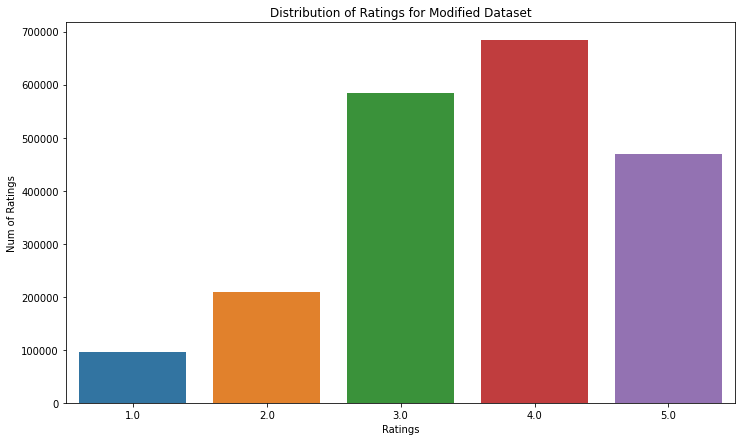

Average rating for the modified dataset: 3.5977




The MAE for the baseline prediction model using statistical computation is: 0.766 for the Netflix Dataset
The Statistical Prediction Baseline Model took 20.815 seconds to run
 


Initializing the training of the baseline model through gradient descent

One instance of the training cycle has finished with 1 epoch(s)
One instance of the training cycle has finished with 5 epoch(s)
One instance of the training cycle has finished with 10 epoch(s)
One instance of the training cycle has finished with 50 epoch(s)


One instance of the training cycle has finished with 100 epoch(s)







The Gradient Descent Baseline Model took 18328.927 seconds to run

For the Netflix Dataset, the following MAE's were recorded for the specified number of epochs for that instance:

For an instance with 1 epoch(s) the MAE is: 1.745
For an instance with 5 epoch(s) the MAE is: 0.792
For an instance with 10 epoch(s) the MAE is: 0.786
For an instance with 50 epoch(s) the MAE is: 0.782
For an instance with 100 epoch(s) the MAE is: 0.781



In [ ]:
def main():

    #Utilize the time package to keep track of the duration of your algorithm implementations
    DataAnalysis()
    # BASELINE STATISTICAL COMPUTATION
    start = time.time()
    NetflixMAE = BaselineStatisticalMethod(train, test)
    end = time.time()
    print("The MAE for the baseline prediction model using statistical computation is: " + str(NetflixMAE) + " for the Netflix Dataset")
    print("The Statistical Prediction Baseline Model took " + str(round(end - start, 3)) + " seconds to run\n \n")

    # BASELINE GRADIENT DESCENT
    print("\n" + "Initializing the training of the baseline model through gradient descent\n")
    mae_out = []
    epochs = [1, 5, 10, 50, 100]
    n = 0
    epoch_maes = np.empty((2, 5)) # Row 1 is MOVIELENS data ROW 2 is Yelp data
    start2 = time.time()
    while n <= 4:
      epoch_maes[0][n] = BaselineGradientDescent(train, test, "Netflix", epochs[n])
      print("One instance of the training cycle has finished with " + str(epochs[n]) + " epoch(s)" )
      mae_out.append(epoch_maes[0][n])
      n +=1
    
    print("\n")
    print("\n")
    print("\n")
    
    end2 = time.time()
    print("\nThe Gradient Descent Baseline Model took " + str(round(end2 - start2, 3)) + " seconds to run\n")
    print("For the Netflix Dataset, the following MAE's were recorded for the specified number of epochs for that instance:\n")
    for i in range(n):
      print("For an instance with " + str(epochs[i]) + " epoch(s) the MAE is: " + str(epoch_maes[0][i]))
    print()

    np.savetxt("Netflix-GD-MAES.txt", np.array(mae_out), fmt="%s")  # This saved the maes for the learning rates(GRADIENTDESCENTMAES.txt) in the list "learn_rates" and I chose the min mae for the learn rate

    

if __name__ == '__main__':
    main()